In [ ]:
!pip install transformers

In [2]:
import os
import tensorflow as tf
import torch
import transformers

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

print(f'TF Version: {tf.__version__}')
print(f'PT Version: {torch.__version__}')
print(f'HF Version: {transformers.__version__}')

TF Version: 2.7.1
PT Version: 1.9.1+cu102
HF Version: 4.21.1


In [ ]:
!wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/images/imagenet-mini-sample.zip && unzip imagenet-mini-sample.zip >/dev/null 2>&1
!wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/images/imagenet-mini.zip && unzip imagenet-mini.zip >/dev/null 2>&1

In [3]:
from PIL import Image
from tqdm.auto import tqdm
from fnmatch import fnmatch
from timeit import default_timer as timer

root = './imagenet-mini-sample'
pattern = "*.JPEG"
all_images = []

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            all_images.append(os.path.join(path, name))

print(len(all_images))

3544


In [4]:
all_images[:1]

['./../test/imagenet-mini-sample/n01614925_3542.JPEG']

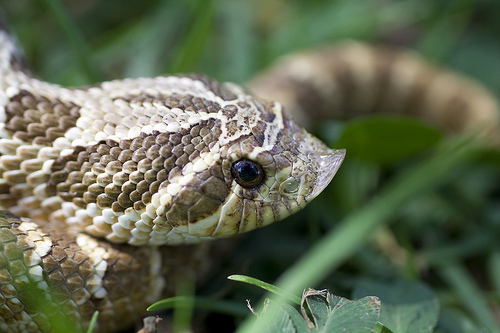

In [5]:
Image.open('./imagenet-mini-sample/n01729322_18506.JPEG').convert("RGB")

## PyTorch CPU

In [6]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [7]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __len__(self):
        return len(all_images)

    def __getitem__(self, i):
        return all_images[i]


dataset = MyDataset()

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", model=model, feature_extractor=feature_extractor, device=-1)
    
for batch_size in [1, 8, 32, 64, 128]:
    print("-" * 30)
    print(f"Streaming batch_size={batch_size}")
    for out in tqdm(pipe(dataset, batch_size=batch_size), total=len(dataset)):
        pass

- Results of the itterations (Jupyter doesn't keep tqdm progress bars/numbers so I go with a screenshot)

<img src="image/dell - hf - mini - torch - cpu.png" width="800">

## PyTorch GPU

In [9]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model = model.to(device)

cuda:0


In [10]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __len__(self):
        return len(all_images)

    def __getitem__(self, i):
        return all_images[i]


dataset = MyDataset()

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", model=model, feature_extractor=feature_extractor, device=0)

for batch_size in [1, 8, 32, 64, 128, 256, 512, 1024]:
    print("-" * 30)
    print(f"Streaming batch_size={batch_size}")
    for out in tqdm(pipe(dataset, batch_size=batch_size), total=len(dataset)):
        pass
    

- Results of the itterations (Jupyter doesn't keep tqdm progress bars/numbers so I go with a screenshot)

<img src="image/dell - hf - mini - torch - gpu.png" width="800">

### Larger Dataset

In [12]:
import os
from PIL import Image
from tqdm.auto import tqdm
from timeit import default_timer as timer
from fnmatch import fnmatch

root = './imagenet-mini'
pattern = "*.JPEG"
all_images = []

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            all_images.append(os.path.join(path, name))

print(len(all_images))

34745


## PyTorch CPU

In [16]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [17]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __len__(self):
        return len(all_images)

    def __getitem__(self, i):
        return all_images[i]


dataset = MyDataset()

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", model=model, feature_extractor=feature_extractor, device=-1)

# the best batch size while using CPUs on this machine
batch_size = 8

print(f"Streaming batch_size={batch_size}")
for out in tqdm(pipe(dataset, batch_size=batch_size), total=len(dataset)):
    pass


- Results of the itterations (Jupyter doesn't keep tqdm progress bars/numbers so I go with a screenshot)

<img src="image/dell - hf - full - torch - cpu.png" width="800">

## PyTorch GPU

In [13]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch

device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(device)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model = model.to(device)

cuda:1


In [14]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __len__(self):
        return len(all_images)

    def __getitem__(self, i):
        return all_images[i]


dataset = MyDataset()

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", model=model, feature_extractor=feature_extractor, device=1)

# the best batch size while using a GPU on this machine
batch_size = 256

print(f"Streaming batch_size={batch_size}")
for out in tqdm(pipe(dataset, batch_size=batch_size), total=len(dataset)):
    pass


- Results of the itterations (Jupyter doesn't keep tqdm progress bars/numbers so I go with a screenshot)

<img src="image/dell - hf - full - torch - gpu.png" width="800">

### Hardware

In [1]:
!lscpu

!free -h

!nvidia-smi

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                80
On-line CPU(s) list:   0-79
Thread(s) per core:    2
Core(s) per socket:    20
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 79
Model name:            Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
Stepping:              1
CPU MHz:               1500.640
CPU max MHz:           3600.0000
CPU min MHz:           1200.0000
BogoMIPS:              4401.48
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              51200K
NUMA node0 CPU(s):     0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78
NUMA node1 CPU(s):     1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79
Flags:            